In [48]:
from finance_news_scraper.mongo_client import MongoDBClient
from finance_stock_scraper.QuestClient import QuestClient
from finance_stock_scraper.TickerRepository import TickerRepository
from finance_stock_scraper.model.Ticker import Ticker

from datetime import date,datetime
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
from mplfinance._styledata import _styles
from mplfinance._mplwraps import _check_for_and_apply_style

STYLE = _styles['yahoo']

### Setup the Clients and connect to the server

In [49]:
IP = "192.168.2.110"
mongoClient = MongoDBClient(host=IP)
questClient = QuestClient(host=IP,port=9001)
tickerRepository = TickerRepository(questClient)

Define the Ticker and retrieve the stock data

In [50]:
TICKER = "GOOGL"
EXCHANGE = "NASDAQ"
START_TIME = datetime(2022,8,8)
END_TIME = datetime(2022,8,12)
#Define the ticker
ticker = Ticker(TICKER,EXCHANGE)
#Get data from QuestDB
df_daily = tickerRepository.get_values(tickers=ticker,interval="1d",values=["open","close","high","low","volume"])
df_minutly = tickerRepository.get_values(tickers=ticker,interval="5m",values=["open","close","high","low","volume"],start_time=START_TIME,end_time=END_TIME)

Plot the Data with mplfinance

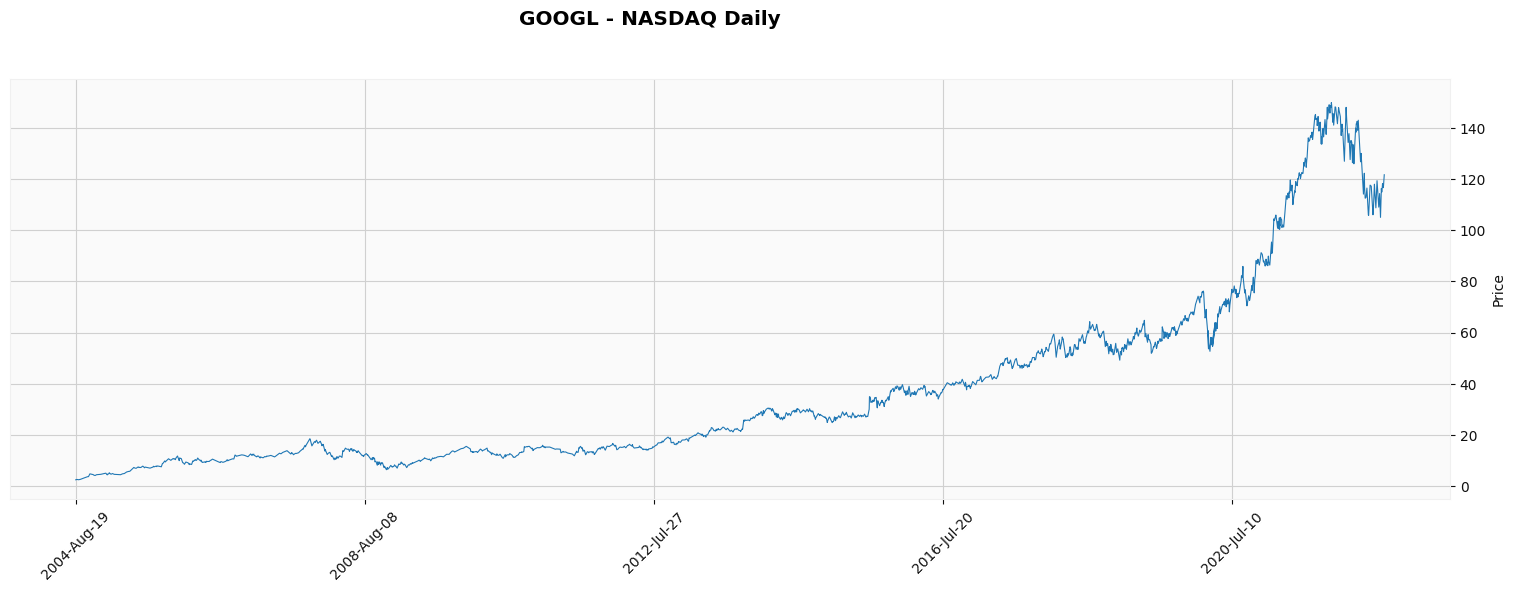

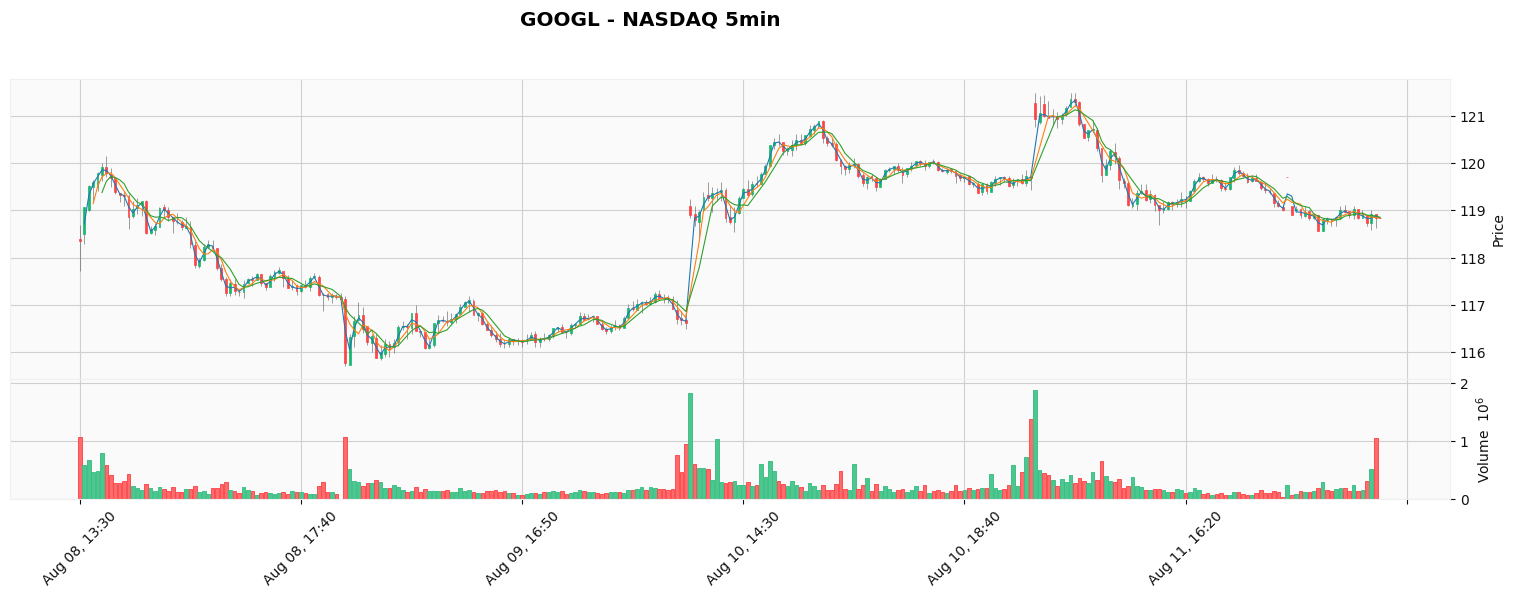

In [51]:
mpf.plot(df_daily,type='line',style=STYLE,title=f"{TICKER} - {EXCHANGE} Daily",figsize=(20,6))
mpf.show()

mpf.plot(df_minutly,type='candle',mav=(2,4,6),volume=True,style=STYLE,title=f"{TICKER} - {EXCHANGE} 5min",figsize=(20,6))
mpf.show()

Get some articles from the news API

In [52]:
for article in mongoClient.get_articles([TICKER])[:5]:
    print(f"{article['date']}: {article['url']}")

2022-08-14 08:30:00: https://www.fool.com/investing/2022/08/14/time-for-faang-stock-flex-its-muscle-alphabet/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article
2022-08-14 08:00:00: https://www.wsj.com/articles/not-upgrading-this-year-how-to-make-your-old-phone-last-11660362817?siteid=yhoof2
2022-08-14 05:21:00: https://www.fool.com/investing/2022/08/14/4-time-tested-stocks-can-build-generational-wealth/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article
2022-08-14 02:12:00: https://finance.yahoo.com/news/10-stocks-buy-according-centiva-061207190.html
2022-08-13 13:58:00: https://www.thestreet.com/technology/legendary-financier-george-soros-bets-big-on-amazon-and-alphabet?puc=yahoo&cm_ven=YAHOO


Get the mean sentiment from the time frame in hourly intervals

In [53]:
df= mongoClient.get_sentiments(TICKER,frequency="h",start=START_TIME,end=END_TIME)
df

,sentiment
date,
2022-08-08 05:00:00,0.699164
2022-08-08 06:00:00,0.658037
2022-08-08 07:00:00,0.616910
2022-08-08 08:00:00,0.575782
2022-08-08 09:00:00,0.534655
...,...
2022-08-11 12:00:00,0.526593
2022-08-11 13:00:00,0.515370
2022-08-11 14:00:00,0.504148


Plot the sentiment

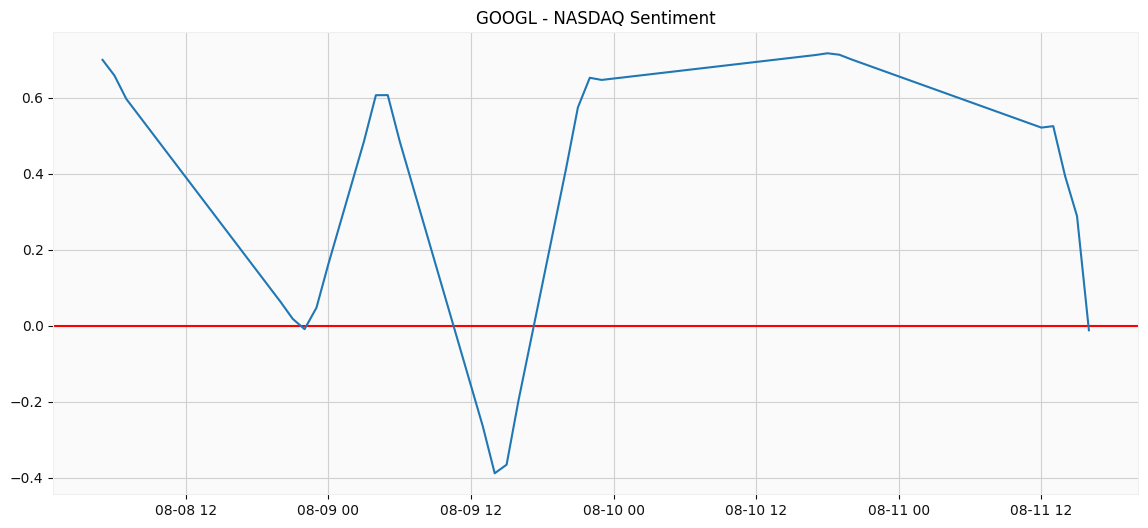

In [54]:
from scipy.signal import savgol_filter

#filter the sentiment to make it smoother
filtered_sentiment = savgol_filter(df['sentiment'],4, 2)
plt.figure(figsize=(14,6))
plt.title(f"{TICKER} - {EXCHANGE} Sentiment")
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(df.index,filtered_sentiment)

Plot the prices over the sentiment

Text(0.5, 1.0, 'Sentiment')

<Figure size 1400x600 with 0 Axes>

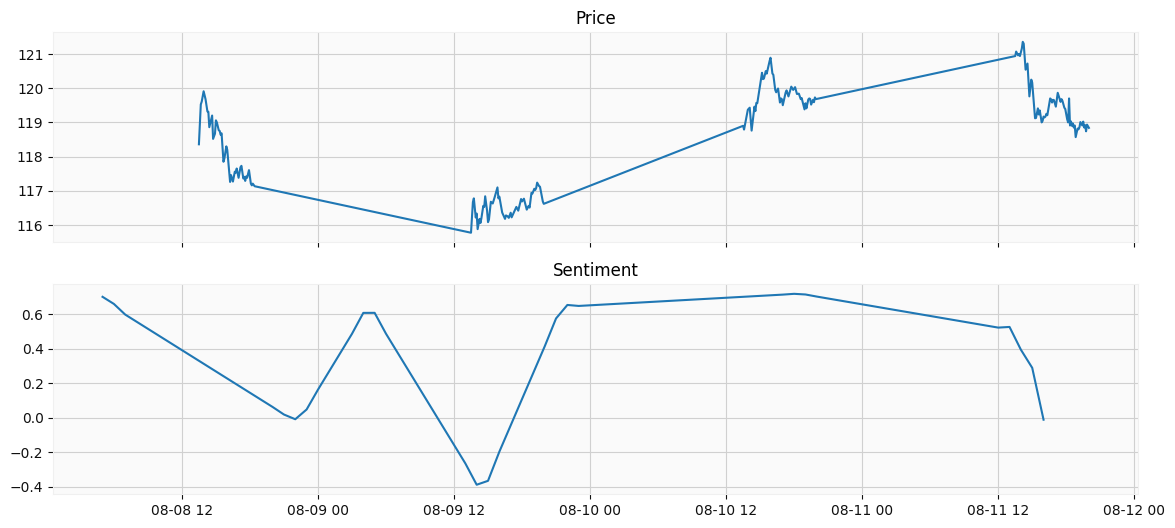

In [55]:
plt.figure(figsize=(14,6))
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True,figsize=(14,6))
ax1.plot(df_minutly['close'])
ax1.set_title("Price")
ax2.plot(df.index,filtered_sentiment)
ax2.set_title("Sentiment")